## Aman's ML process:
1. Problem
2. Data
3. Algorithm
4. Discovery

## References
* TF-IDF
    * [hackernoon](https://hackernoon.com/finding-the-most-important-sentences-using-nlp-tf-idf-3065028897a3)
* [Beginners Guide to NLP](https://towardsdatascience.com/a-beginners-guide-to-natural-language-processing-e21e3e016f84)
* [How to Prepare Text Data for ML using sklearn](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

### From Presentation
* Chris
    * use [pickle](https://docs.python.org/3/library/pickle.html) to save python objects
    * use [Chi-2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) to find highly correlated keywords
    * used [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to reduced all the features in TF-IDF into 2D for visualization
    * added score by sentence appearance in the article: beginning and end have higher scores
* Tranq
    * use pretrained word vectors [GloVe](https://nlp.stanford.edu/projects/glove/)
    * used [cosine similarirty](https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50) and [NetworkX](https://networkx.github.io/) to rank sentences instead of TF-IDF

## Classifying Articles

* finding a corpus
* theme
* assigning those themes to new articles

# Part 1 - Getting Data
* using [feedparser](https://pythonhosted.org/feedparser/) (code from [stackoverflow](https://stackoverflow.com/questions/45701053/get-feeds-from-feedparser-and-import-to-pandas-dataframe)) to get all feeds from [the Zennist blog](https://zennist.typepad.com/zenfiles/atom.xml)
* also used [newspaper](https://github.com/codelucas/newspaper) following sample code from [here](http://seangtkelley.me/blog/2018/01/03/news-article-clustering)

In [244]:
import feedparser, requests
from newspaper import Article
from bs4 import BeautifulSoup
import re

import pandas as pd
import numpy as np

In [320]:
def GetArticleRSS( lRSS , getSummary = True, verbose = 0 ):
    posts = [] 
    for url in lRSS:
        if verbose:
            print(f'Getting feed from {url}...')
        feed = feedparser.parse(url)

        for post in feed.entries:
            if verbose:
                print(f' Saving {post.title}: article length {len(post.content[0].value)}, summary length {len(post.summary)}')
            
            content = post.content[0].value
            if getSummary:
                content = post.summary
            
            posts.append([post.title, post.link, content])

    df = pd.DataFrame(posts, columns=['title', 'link', 'content'])
    return df

def GetNewsRSS( lRSS, verbose =0):
    posts = [] 
    for rss_index, url in enumerate(lRSS):
        if verbose:
            print(f'Getting feed from {url}...')
        feed = feedparser.parse(url)

        for post in feed.entries:
            if verbose:
                print(f' Saving {post.title}: {post.link}')
            
            post_url = post.link
            content = Article(post_url)
            #try:
            content.download()
            content.parse()
            posts.append([post.title, post_url, content.text, rss_index])
            #except: # This is Dangerous I know
            #except ArticleException:
                # likely timeout error, let's continue
            #    continue

    df = pd.DataFrame(posts, columns=['title', 'link', 'content', 'source'])
    return df

def GetZenArticles():
    raw_rss = [
        'https://zennist.typepad.com/zenfiles/atom.xml'
    ]
    return GetArticleRSS( raw_rss , getSummary= False, verbose = 0)

def GetEconomistArticles():
    raw_rss = [
        'https://www.economist.com/asia/rss.xml',
#         'https://www.economist.com/united-states/rss.xml',
#         'https://www.economist.com/the-americas/rss.xml',
#         'https://www.economist.com/britain/rss.xml',
#         'https://www.economist.com/europe/rss.xml',
#         'https://www.economist.com/middle-east-and-africa/rss.xml',
#         'https://www.economist.com/china/rss.xml'
    ]
    return GetNewsRSS( raw_rss, verbose =0 )
    
def GetNewsArticles():
    rawrss = [
        'http://rss.nytimes.com/services/xml/rss/nyt/ProBasketball.xml',
        'http://rss.nytimes.com/services/xml/rss/nyt/ProFootball.xml',
        'http://rss.nytimes.com/services/xml/rss/nyt/Hockey.xml',
        'http://rss.nytimes.com/services/xml/rss/nyt/Soccer.xml',
#         'http://newsrss.bbc.co.uk/rss/newsonline_uk_edition/front_page/rss.xml',
#         'https://www.yahoo.com/news/rss/',
#         'http://www.huffingtonpost.co.uk/feeds/index.xml',
#         'http://feeds.feedburner.com/TechCrunch/'
        ]
    return GetNewsRSS(rawrss, verbose = 0)

In [247]:
data = GetNewsArticles()

In [248]:
raw = data.loc[0, ['content']].values
raw[0]

'The team and agent both said Fultz’s condition would be treated with physical therapy, and ESPN’s report indicated Fultz could be back on the court in three to six weeks.\n\nThis condition, which the Mayo Clinic says involves a compression of the brachial plexus, “a network of nerves that come from your spinal cord and control muscle movements and sensation in your shoulder, arm and hand,” is typically more associated with baseball players. A host of big-name pitchers, including Matt Harvey, Josh Beckett and Chris Carpenter, have received a similar diagnosis. In perhaps that sport’s most famous case, J.R. Richard, an all-star pitcher for the Houston Astros, had his promising career ended by what was described as vascular thoracic outlet syndrome and a subsequent stroke that was attributed to the condition.\n\nIn Fultz’s case, a diagnosis of an actual physical ailment, even a serious one like this, could be a step forward for his career, as it could clear up the perception that his str

In [249]:
data.shape

(80, 3)

# Part 2- Parse Data
for details on [stemming and lemmatization, see this article](https://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization)

let's get [better stopwords](https://github.com/igorbrigadir/stopwords), I like [Ranks NL's](https://www.ranks.nl/stopwords)

In [250]:
def GetNLStopWords():
    sw_url = 'https://raw.githubusercontent.com/igorbrigadir/stopwords/master/en/ranksnl_large.txt'
    response = requests.get(sw_url)
    line = response.text.split('\n')
    return line

nl_stopwords = GetNLStopWords()

In [332]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

def cleanText( inTxt ):
    soup = BeautifulSoup(inTxt, 'html.parser')
    raw = soup.get_text()
    raw = raw.replace(u'\xa0', u' ')
    raw = raw.replace(u'\n', u' ')
    return raw

def getTok( inTxt ):
    custom_stopwords = [
#         'team',
#         'player',
#         'play',
#         'playing',
#         'game'
    ]
    
    our_stopwords = set( stopwords.words('english') + list(punctuation) + nl_stopwords + custom_stopwords)
    
    # Make the words to lower
    txt = inTxt.lower()
    
    # Remove None Alphabetic Characters
    txt_nd = re.sub('[^A-za-z]', ' ', txt)
    
    wtok = [w for w in word_tokenize( txt_nd) if w not in our_stopwords]
    stok = sent_tokenize( txt)
    
#     # stemming
#     stemmer = PorterStemmer()
#     for i in range(len(wtok)):
#         wtok[i] = stemmer.stem( wtok[i])
    
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    for i in range(len(wtok)):
        wtok[i] = lemmatizer.lemmatize( wtok[i])
    
    # Spell Correction?
#     from autocorrect import spell
#     tokenized_sms[i] = stemmer.stem(spell(tokenized_sms[i]))
    
    return wtok, stok

In [252]:
txt = cleanText(raw[0])
wtok, stok = getTok( txt )

# Part 3- Analyze
* following this [article on Text Classifcation using Bag of Words](https://www.linkedin.com/pulse/text-classification-using-bag-words-approach-nltk-scikit-rajendran)
* [ultimate guide to deal with Text Data for Data Scientists](https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/)
* ideas:
    * [hashing trick](https://medium.com/value-stream-design/introducing-one-of-the-best-hacks-in-machine-learning-the-hashing-trick-bf6a9c8af18f)

In [333]:
def GetCorpus():
    feeds = GetNewsArticles()
    feeds['clean_content'] = feeds['content'].apply(lambda x : cleanText(x))
    feeds['word_tok'] = feeds['clean_content'].apply( lambda x : getTok(x)[0] )
    feeds['tok_join'] = feeds['word_tok'].apply( lambda x : ' '.join(x) )
    return feeds

dataset = GetCorpus()

## Little bit of EDA

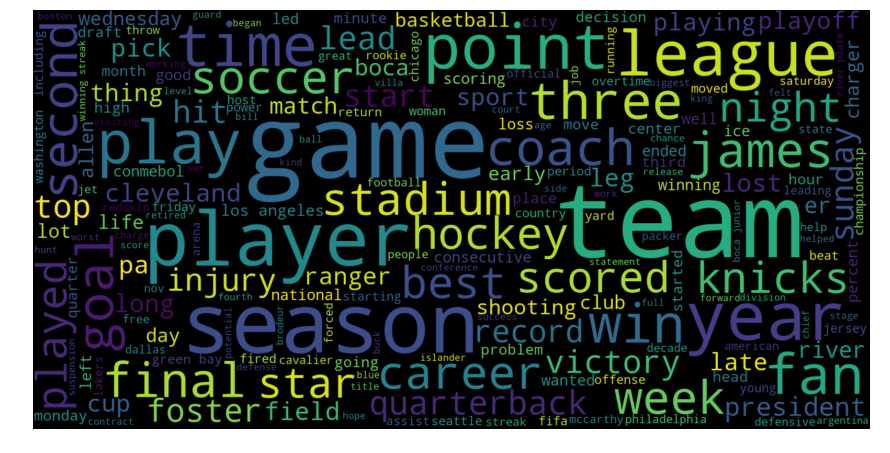

In [337]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

corpus_text = " ".join(list(dataset['tok_join']))
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(corpus_text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Unsupervised Classifier

In [338]:
from sklearn.feature_extraction.text import CountVectorizer

matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform( dataset['tok_join'])
count_vocab = matrix.get_feature_names()
print(f'Count Vector matrix shape: {X.shape}')

Count Vector matrix shape: (80, 1000)


In [339]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_features=1000, use_idf= True, max_df = 0.8 , min_df = 0.2)
tfidf_mat = tfidf_vect.fit_transform( dataset['tok_join'])
tfidf_vocab = tfidf_vect.get_feature_names()
print(f'TF-IDF matrix shape: {tfidf_mat.shape}')

TF-IDF matrix shape: (80, 23)


# Part 4 - Machine Learning: Classification

In [325]:
# kmeans
from sklearn.cluster import KMeans

# Navie Bayes
from sklearn.naive_bayes import GaussianNB

In [340]:
k_means_c = KMeans( n_clusters= 4, random_state= 420)
k_means_t = KMeans( n_clusters= 4, random_state= 420)
dataset['count_vect_cluster'] = k_means_c.fit_predict(X)
dataset['tfidf_cluster'] = k_means_t.fit_predict(tfidf_mat)

In [341]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(dataset.count_vect_cluster, dataset.tfidf_cluster)
print(f'Accuracy Score between Counter Vectorization and TF-IDF: {"{:.2f}".format(accuracy)}')

Accuracy Score between Counter Vectorization and TF-IDF: 0.07


# Part 5- Evaluate the Classification

In [342]:
def GetClusterDet(l_vocab , centroid, n_top):
    if len(centroid) != len(l_vocab):
        return None
    else:
        df_feat = pd.DataFrame({
            'vocab': l_vocab,
            'score': centroid
        })
        df_feat= df_feat.sort_values(by = 'score', ascending= False)
        return list(df_feat.vocab[: n_top ])
    
GetClusterDet( tfidf_vocab, k_means_t.cluster_centers_[0], 6)

['game', 'point', 'second', 'season', 'night', 'time']

In [343]:
def PrintClustersDetails(l_centroids, df_cluster, l_vocab, n_kw = 6, n_title = 5):
    # l_centroids should be list of centroid from the clasification model
    # df_cluster should have a column named 'title' and 'cluster'

    print("Details by clusters:\n")
    for idx, centroid in enumerate(l_centroids):
        print(f'\nCluster {idx}- top {n_kw} keywords: {", ".join(GetClusterDet(l_vocab, centroid, n_kw))}')

        df_sub = df_cluster[ df_cluster.cluster == idx]
        title_count = min( n_title, len(df_sub))
        print(f'Cluster article titles ({title_count} of {len(df_sub)}):')
        
        for title in df_sub['title'][: title_count]:
            print(f'   {title}')


In [344]:
print('Using TF-IDF\n---------------------------------')
PrintClustersDetails( 
    k_means_t.cluster_centers_, 
    dataset.rename(columns={'tfidf_cluster': 'cluster'}), 
    tfidf_vocab, 
    n_kw= 5,
    n_title = 5
)

Using TF-IDF
---------------------------------
Details by clusters:


Cluster 0- top 5 keywords: game, point, second, season, night
Cluster article titles (5 of 33):
   Sixers Guard Markelle Fultz Out Indefinitely With Nerve Disorder
   N.B.A. Roundup: Knicks Rally to Overcome a Big Lead by the Bucks
   Grizzlies 131, Nets 125 | 2 OTS: Nets Squander Late Lead to Lose Their 5th Straight Game
   Unwanted in L.A., Brook Lopez Became Milwaukee’s ‘Splash Mountain’
   On Pro Basketball: How to Improve the 4-17 Suns? Coach Kokoskov’s Got a List

Cluster 1- top 5 keywords: fan, game, final, play, player
Cluster article titles (5 of 13):
   New York’s N.B.A. Teams Don’t Have Much to Celebrate. These Fans Cheer Anyway.
   Adam Silver Can See That You Are Angry, and He Is Here for It
   N.F.L. Week 13 Predictions: Our Picks Against the Spread
   60 Years After Integrating the N.H.L., Willie O’Ree Heads to the Hall of Fame
   On Soccer: A Final for All Time, Sacrificed on the Altar of the Modern G

In [345]:
print('Using Counter Vectorization\n---------------------------------')
PrintClustersDetails( 
    k_means_c.cluster_centers_, 
    dataset.rename(columns={'count_vect_cluster': 'cluster'}), 
    count_vocab, 
    n_kw= 5,
    n_title = 5
)

Using Counter Vectorization
---------------------------------
Details by clusters:


Cluster 0- top 5 keywords: team, player, league, season, foster
Cluster article titles (5 of 19):
   In Australia, a Sudanese Basketball League Finds Itself Sidelined by Racist Fears
   Making Sense of the N.B.A.’s Wacky Start
   The N.F.L. Coaching Carousel Takes a Big Turn. Who’s Next?
   On Pro Football: The N.F.L. Was Soaring. Then a Familiar Demon Reared Its Ugly Head
   Packers Fire Coach Mike McCarthy After Loss to Cardinals

Cluster 1- top 5 keywords: team, year, brodeur, time, division
Cluster article titles (2 of 2):
   N.F.C. East Struggles to Produce a Clear Front-Runner
   Martin Brodeur, Always a Devil, Takes a New Role With the Team

Cluster 2- top 5 keywords: game, season, team, point, play
Cluster article titles (5 of 56):
   Sixers Guard Markelle Fultz Out Indefinitely With Nerve Disorder
   N.B.A. Roundup: Bulls Fire Fred Hoiberg, Citing Lack of ‘Energy and Spirit’
   New York’s N.B.

# Part 6- Predict with K-Nearest (Supervised Classification)

In [352]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split( tfidf_mat, dataset.tfidf_cluster)
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

knn = KNeighborsClassifier( n_neighbors=10)
knn.fit(X_train, y_train )
knn_predict = knn.predict(X_test)

accuracy = accuracy_score(knn_predict, y_test)
print(f'Accuracy Score of KNN trained model using TF-IDF vectorization: {"{:.2f}".format(accuracy)}')

cv_score = cross_val_score( knn, tfidf_mat, dataset.tfidf_cluster, cv = 10)
print(f'Cross Val Score: {"{:.2f}".format(cv_score.mean())}')

Train set shape: (60, 23)
Test set shape: (20, 23)
Accuracy Score of KNN trained model using TF-IDF vectorization: 0.90
Cross Val Score: 0.84


# Part 7- Supervised ML Classification using TF-IDF

In [355]:
k_means_sup = KMeans( n_clusters= 4, random_state= 420)
cv_score = cross_val_score( k_means_sup, tfidf_mat, dataset.source, cv = 10,scoring = 'accuracy')
print(f'Cross Val Score of my supervised k-means classifier using TF-IDF Vectorizer: {cv_score.mean()}')

Cross Val Score of my supervised k-means classifier using TF-IDF Vectorizer: 0.2375
